In [1]:
import pandas as pd
from numpy import sqrt,mean,log,diff
import quandl
import scipy.stats as stats
from scipy import interpolate 
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import animation
from pandas_datareader.data import Options
import pandas_datareader.data as web
import datetime
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [1010]:
quandl.ApiConfig.api_key = 'NxTUTAQswbKs5ybBbwfK'

In [1011]:
data = quandl.get('WIKI/GOOG')

In [1012]:
# use the daily data of Google(NASDAQ: GOOG) from 01/2016 to 08/2016 
close = data['2016-01':'2016-08']['Adj. Close']
r = diff(log(close))
r_mean = mean(r)
diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
std = sqrt(sum(diff_square)*(1.0/(len(r)-1)))
vol = std*sqrt(252)
vol

0.21326449960467742

In [2]:
def bsm_price(option_type, sigma, s, k, r, T, q):  
    # calculate the bsm price of European call and put options
    sigma = float(sigma)
    d1 = (np.log(s / k) + (r - q + sigma ** 2 * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        price = np.exp(-r*T) * (s * np.exp((r - q)*T) * stats.norm.cdf(d1) - k *  stats.norm.cdf(d2))
        return price
    elif option_type == 'p':
        price = np.exp(-r*T) * (k * stats.norm.cdf(-d2) - s * np.exp((r - q)*T) *  stats.norm.cdf(-d1))
        return price
    else:
        print('No such option type %s') %option_type

In [3]:
def implied_vol(option_type, option_price, s, k, r, T, q):
    # apply bisection method to get the implied volatility by solving the BSM function
    precision = 0.00001
    upper_vol = 500.0
    max_vol = 500.0
    min_vol = 0.0001
    lower_vol = 0.0001
    iteration = 0    

    while 1:
        iteration +=1 
        mid_vol = (upper_vol + lower_vol)/2.0
        price = bsm_price(option_type, mid_vol, s, k, r, T, q)
        if option_type == 'c':

            lower_price = bsm_price(option_type, lower_vol, s, k, r, T, q)
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_vol = mid_vol 
            else:
                upper_vol = mid_vol
            if abs(price - option_price) < precision: break
            if mid_vol > max_vol - 5 : 
                mid_vol = 0.000001
                break
#             print("mid_vol=%f" %mid_vol)
#             print("upper_price=%f" %lower_price)

        elif option_type == 'p':
            upper_price = bsm_price(option_type, upper_vol, s, k, r, T, q)

            if (upper_price - option_price) * (price - option_price) > 0:
                upper_vol = mid_vol 
            else:
                lower_vol = mid_vol            
#             print("mid_vol=%f" %mid_vol)
#             print("upper_price=%f" %upper_price)            
            if abs(price - option_price) < precision: break 
            if iteration > 50: break
                
    return mid_vol 

In [95]:
# download option data for all expiry months from Yahoo Finance 
# provide a formatted DataFrame with a hierarchical index
opt = Options('spy', 'yahoo')
opt.expiry_dates  # list all the available expiration dates

[datetime.date(2017, 8, 16),
 datetime.date(2017, 8, 18),
 datetime.date(2017, 8, 23),
 datetime.date(2017, 8, 25),
 datetime.date(2017, 8, 30),
 datetime.date(2017, 9, 1),
 datetime.date(2017, 9, 6),
 datetime.date(2017, 9, 8),
 datetime.date(2017, 9, 13),
 datetime.date(2017, 9, 15),
 datetime.date(2017, 9, 22),
 datetime.date(2017, 9, 29),
 datetime.date(2017, 10, 20),
 datetime.date(2017, 11, 17),
 datetime.date(2017, 12, 15),
 datetime.date(2017, 12, 29),
 datetime.date(2018, 1, 19),
 datetime.date(2018, 3, 16),
 datetime.date(2018, 3, 29),
 datetime.date(2018, 6, 15),
 datetime.date(2018, 6, 29),
 datetime.date(2018, 7, 20),
 datetime.date(2018, 9, 21),
 datetime.date(2018, 12, 21),
 datetime.date(2019, 1, 18),
 datetime.date(2019, 3, 15),
 datetime.date(2019, 6, 21),
 datetime.date(2019, 12, 20),
 datetime.date(2020, 7, 17)]

In [56]:
def IV_plot(opt,option_type,expiry_index):
    expiry = opt.expiry_dates[expiry_index]
    if option_type == 'c':
        data = opt.get_call_data(expiry=expiry)
    elif option_type == 'p':
        data = opt.get_put_data(expiry=expiry)
    r = 0.01 # risk free rate
    d = 0.01 # continuous devidend yield
    s = opt.underlying_price # data_call['Underlying_Price']  undelying price
    expiry = data.index.get_level_values('Expiry')[0] # get the expiry 
    current_date = opt.quote_time # current_date = datetime.datetime.now() # get the current date
    time_to_expire = float((expiry - current_date).days)/365 # compute time to expiration
    premium = (data['Ask'] + data['Bid'])/2 # option premium
    strike = list(data.index.get_level_values('Strike')) # get the strike price
    IV = []
    for i in range(len(data)):  
        IV.append(implied_vol(option_type, premium.values[i], s, strike[i], r, time_to_expire, d))
   
    plt.figure(figsize=(16, 7))
    a = plt.scatter(strike,IV, c='r', label="IV by solving BSM")
    b = plt.scatter(strike,data['IV'],c = 'b', label="IV from Yahoo Finance")
    plt.grid()
    plt.xlabel('strike')
    if option_type == 'c':
        plt.ylabel('Implied Volatility for call option')
        plt.legend((a,b), ("IV(call) by solving BSM", "IV(call) from Yahoo Finance"))
    elif option_type == 'p':
        plt.ylabel('Implied Volatility for put options')
        plt.legend((a,b), ("IV(put) by solving BSM", "IV(put) from Yahoo Finance"))
    
    return strike,IV

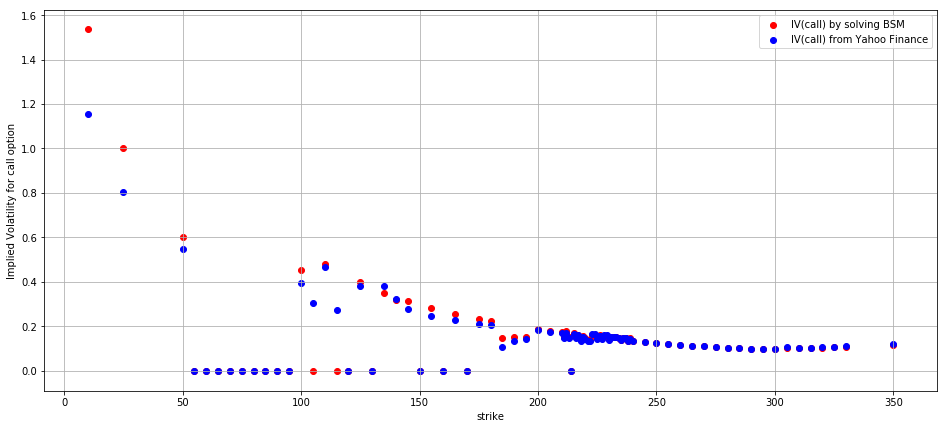

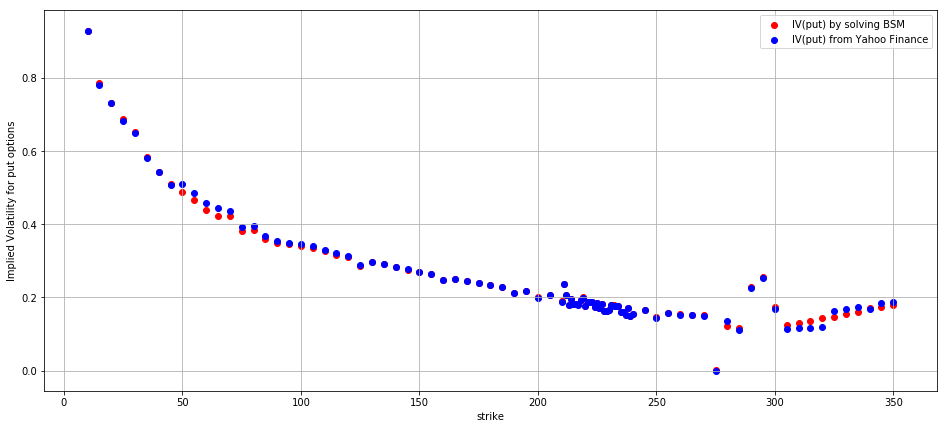

In [88]:
k_call, IV_call = IV_plot(opt,'c',23)
k_put, IV_put = IV_plot(opt,'p',23)

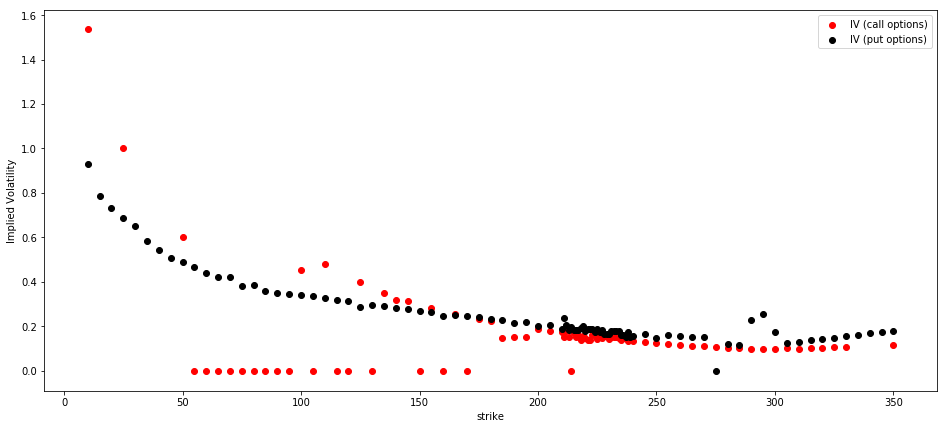

In [89]:
plt.figure(figsize=(16, 7))
e = plt.scatter(k_call,IV_call, c ='red', label="IV(call options)")
f = plt.scatter(k_put,IV_put, c = 'black', label="IV(put options)")
plt.xlabel('strike')
plt.ylabel('Implied Volatility')
plt.legend((e,f), ("IV (call options)", "IV (put options)"))

In [90]:
r = 0.01 # risk free rate
d = 0.01 # continuous devidend yield
expiry_dates = [i for i in opt.expiry_dates if i > opt.quote_time.date()]
current_date = opt.quote_time.date()  ## get the current date
s = opt.underlying_price # undelying price
num_expiry = len(expiry_dates)
IV = [] # (num_expiry * 3)-dimension list with each row being [time_to_expire, strike, implied_vol]

for expiry_index in range(num_expiry):
    data = opt.get_put_data(expiry=expiry_dates[expiry_index])
    expiry = expiry_dates[expiry_index] # get the expiry  
    time_to_expire = float((expiry - current_date).days)/365 # compute time to expiration    
    premium = (data['Ask'] + data['Bid'])/2.0 # option premium
    strike = data.index.get_level_values('Strike') # get the strike price
    num_strike = len(data)
    for j in range(num_strike):  
        IV.append([time_to_expire, strike[j], implied_vol('c', premium.values[j], s, strike[j], r, time_to_expire, d)])    

In [91]:
#  IV = [i for i in IV if i[2]>0.01 and i[2]<3] # delete the implied volatility with 0 value or much higher value

In [92]:
x= [IV[i][0] for i in range(len(IV))]
y= [IV[i][1] for i in range(len(IV))]
z= [IV[i][2] for i in range(len(IV))]

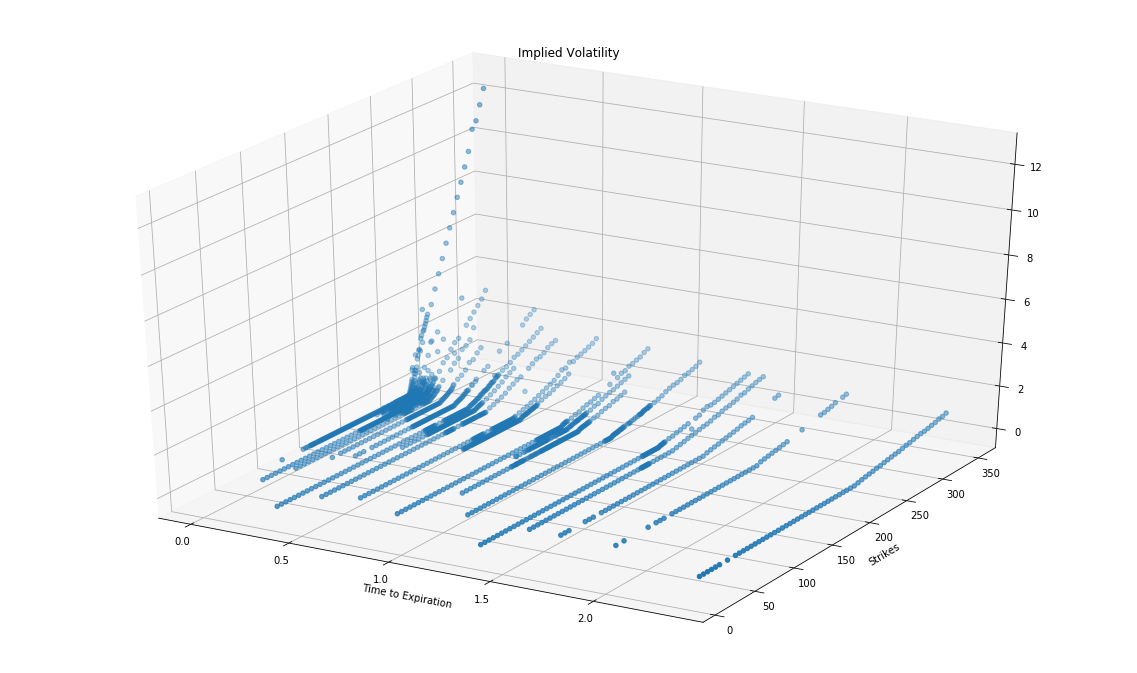

In [105]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init()
ax.scatter(x,y,z)
plt.xlabel("Time to Expiration")
plt.ylabel("Strikes")
plt.title("Implied Volatility")